<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher_New/blob/main/Data_Analysis20231025_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#optPhotoFilesにおけるデータ解析/年齢・性別によるマッチング
opyPhotoFilesにおいては、被検者募集方法の違いのため、control群とRA群の年齢差が大きい。このため、モデルが皮膚の加齢性変化を学習してしまう可能性を否定できない。ここでは両群の年齢と性別の代表値を求め、それらをマッチングさせたデータセットの作成を行う。

#作業環境構築
作業環境としてGoogleDriveをマウントし、統計解析、図表描画に必要なライブラリをインポートする。

In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Google Driveのマウント
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#データセットの参照
'optPhotoFiles_cleaning20231025'を使用してデータクリーニングと背景の消去を終えたoptPhotoFiles_nonRAとoptPhotoFiles_RAを参照する。

In [2]:
# データの読み込み
ra_df = pd.read_csv("/content/drive/MyDrive/OptPhotoFiles/optPhotoTable/optPhotoTable_for_use/optPhotoTable_RA20231025.csv")
control_df = pd.read_csv("/content/drive/MyDrive/OptPhotoFiles/optPhotoTable/optPhotoFiles_controls_20231026/optPhotoTable_controls.csv")

RA group - Mean age: 69.46, Median age: 71.0, Standard Deviation: 13.05, Q1: 63.0, Q3: 80.0
Control group - Mean age: 39.01, Median age: 37.0, Standard Deviation: 12.11, Q1: 30.0, Q3: 46.0
RA group age distribution:
10-14: 0
15-19: 0
20-24: 1
25-29: 1
30-34: 3
35-39: 3
40-44: 3
45-49: 14
50-54: 19
55-59: 16
60-64: 27
65-69: 50
70-74: 41
75-79: 42
80-84: 48
85-89: 20
90-94: 7
95-99: 1

Control group age distribution:
10-14: 0
15-19: 28
20-24: 96
25-29: 157
30-34: 207
35-39: 193
40-44: 158
45-49: 152
50-54: 87
55-59: 46
60-64: 23
65-69: 43
70-74: 6
75-79: 6
80-84: 2
85-89: 1
90-94: 0
95-99: 0


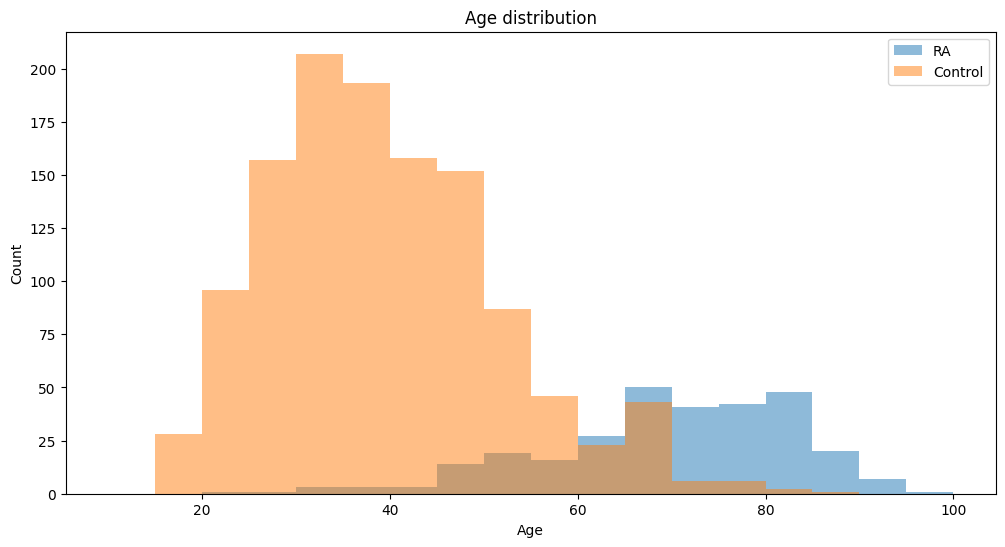

RA group - Female counts:
1    220
0     76
Name: female, dtype: int64
Control group - Female counts:
1.0    652
0.0    553
Name: female, dtype: int64


In [3]:
# 統計量の計算
def get_statistics(df, column_name):
    mean = df[column_name].mean()
    median = df[column_name].median()
    std = df[column_name].std()
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)

    return mean, median, std, q1, q3

mean_ra, median_ra, std_ra, q1_ra, q3_ra = get_statistics(ra_df, "age")
mean_control, median_control, std_control, q1_control, q3_control = get_statistics(control_df, "age")

# 結果の表示
print(f"RA group - Mean age: {mean_ra:.2f}, Median age: {median_ra}, Standard Deviation: {std_ra:.2f}, Q1: {q1_ra}, Q3: {q3_ra}")
print(f"Control group - Mean age: {mean_control:.2f}, Median age: {median_control}, Standard Deviation: {std_control:.2f}, Q1: {q1_control}, Q3: {q3_control}")

# 5歳刻みの度数分布
bins = list(range(10, 105, 5))
ra_hist_values, _ = np.histogram(ra_df["age"], bins=bins)
control_hist_values, _ = np.histogram(control_df["age"], bins=bins)

print("RA group age distribution:")
for i in range(len(bins)-1):
    print(f"{bins[i]}-{bins[i+1]-1}: {ra_hist_values[i]}")

print("\nControl group age distribution:")
for i in range(len(bins)-1):
    print(f"{bins[i]}-{bins[i+1]-1}: {control_hist_values[i]}")

# ヒストグラムの表示
plt.figure(figsize=(12, 6))
plt.hist(ra_df["age"], bins=bins, alpha=0.5, label="RA")
plt.hist(control_df["age"], bins=bins, alpha=0.5, label="Control")
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

# femaleの度数
ra_female_counts = ra_df["female"].value_counts()
control_female_counts = control_df["female"].value_counts()

print(f"RA group - Female counts:\n{ra_female_counts}")
print(f"Control group - Female counts:\n{control_female_counts}")


In [4]:
# 年齢のカテゴリを作成する関数
def categorize_age(age):
    return (age // 5) * 5

# 年齢カテゴリの列を追加
ra_df['age_category'] = ra_df['age'].apply(categorize_age)
control_df['age_category'] = control_df['age'].apply(categorize_age)

matched_samples = []

# 5歳刻みのカテゴリごとにループ
for age_cat in range(15, 100, 5):
    for gender in [0, 1]:
        ra_sample = ra_df[(ra_df['age_category'] == age_cat) & (ra_df['female'] == gender)]
        control_sample = control_df[(control_df['age_category'] == age_cat) & (control_df['female'] == gender)]

        # 最小のサイズに合わせる
        sample_size = min(len(ra_sample), len(control_sample))

        # サンプリング
        ra_sample = ra_sample.sample(n=sample_size, random_state=42)
        control_sample = control_sample.sample(n=sample_size, random_state=42)

        # 結果をリストに追加
        matched_samples.extend([ra_sample, control_sample])

# 全てのサンプルを統合
matched_df = pd.concat(matched_samples, ignore_index=True)

# 結果の表示
print(matched_df)

      age  female   RA  arthralgia        right_hand_filename  \
0    20.0     1.0  1.0         0.0     RA_right_hand_196_.jpg   
1    22.0     1.0  0.0         0.0    nonRA_right_hand_78.jpg   
2    29.0     1.0  1.0         0.0     RA_right_hand_222_.jpg   
3    27.0     1.0  0.0         0.0  nonRA_right_hand_1129.jpg   
4    33.0     0.0  1.0         1.0     RA_right_hand_167_.jpg   
..    ...     ...  ...         ...                        ...   
227  82.0     1.0  1.0         1.0     RA_right_hand_144_.jpg   
228  81.0     1.0  0.0         0.0   nonRA_right_hand_934.jpg   
229  80.0     1.0  0.0         0.0   nonRA_right_hand_932.jpg   
230  85.0     1.0  1.0         0.0     RA_right_hand_257_.jpg   
231  85.0     1.0  0.0         1.0   nonRA_right_hand_857.jpg   

        left_hand_filename    num        id  age_category  
0    RA_left_hand_196_.jpg  208.0  225614.0          20.0  
1                      NaN    NaN       NaN          20.0  
2    RA_left_hand_222_.jpg  234.0  2214

In [5]:
# matched_dfをCSVとして保存
save_path = "/content/drive/MyDrive/OptPhotoFiles/optPhotoTable/matched_samples.csv"
matched_df.to_csv(save_path, index=False)
print(f"Saved matched_df to {save_path}")

Saved matched_df to /content/drive/MyDrive/OptPhotoFiles/optPhotoTable/matched_samples.csv


In [6]:
import os
import shutil

# 画像をコピーする関数
def copy_image(row):
    if row['RA'] == 1:
        source_dir = "/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/RA/RA_Right_Hand_4th"
    else:
        source_dir = "/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/nonRA/nonRA_Right_Hand_5th"

    destination_dir = "/content/drive/MyDrive/OptPhotoFiles/optPhotoTable/matched_samples"
    # ディレクトリが存在しない場合、ディレクトリを作成
    if not os.path.exists(destination_dir):
      os.makedirs(destination_dir)

    source_path = os.path.join(source_dir, row['right_hand_filename'])
    destination_path = os.path.join(destination_dir, row['right_hand_filename'])

    # ファイルをコピー
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)

# すべての行に対して上記の関数を適用
matched_df.apply(copy_image, axis=1)

print("Files copied successfully!")

Files copied successfully!


In [7]:
# 対象のディレクトリ
target_dir = "/content/drive/MyDrive/OptPhotoFiles/optPhotoTable/matched_samples"

# ファイル数を計算
file_count = sum([len(files) for _, _, files in os.walk(target_dir)])

print(f"Total number of files in {target_dir}: {file_count}")

Total number of files in /content/drive/MyDrive/OptPhotoFiles/optPhotoTable/matched_samples: 229


In [8]:
import os
import pandas as pd

# 指定したディレクトリのパス
directory_path = '/content/drive/MyDrive/OptPhotoFiles/optPhotoTable/matched_samples'

# ディレクトリ内のファイル名をリストに格納
file_names = os.listdir(directory_path)

# リストをDataFrameに変換
df = pd.DataFrame(file_names, columns=['File Names'])

# 保存先のパスを指定
save_path = '/content/drive/MyDrive/file_names.xlsx'

# DataFrameをExcelファイルとして保存
df.to_excel(save_path, index=False)
